<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/Multi_tree_Genetic_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-tree Genetic Program 

In [ ]:
!pip install deap
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data

In [ ]:
"""
Data - data.py
==============

This is the data module. It contains the functions for loading, preparing, normalizing and encoding the data.
"""

import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import scipy.io


def encode_labels(y, y_test=None):
    """
    Convert text labels to numbers.

    Args:
        y: The labels.
        y_test: The test labels. Defaults to None.
    """
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    if y_test is not None:
        y_test = le.transform(y_test)
    return y, y_test, le


def load(filename, folder=''):
    """
    Load the data from the mat file.

    Args:
        filename: The name of the mat file.
        folder: The folder where the mat file is located.
    """
    path = folder + filename
    mat = scipy.io.loadmat(path)
    return mat


def prepare(mat):
    """
    Load the data from matlab format into memory. 

    Args:
        mat: The data in matlab format.
    """
    X = mat['X']   
    X = X.astype(float)
    y = mat['Y']    
    y = y[:, 0]
    return X,y


def normalize(X_train, X_test):
    """
    Normalize the input features within range [0,1].

    Args:
        X_train: The training data.
        X_test: The test data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


def one_hot_encoding(ys):
    """ Convert a label to onehot encoding. A vector where its argmax, or 1 value, corresponds to the index of the class label. 

    Args: 
        ys: The class

    Returngs: 
        one_hot: The class labels as onehot encoded vectors. 
    """
    n_instances, n_classes = len(ys), len(np.unique(ys))
    one_hot = np.zeros((n_instances, n_classes))
    for i,y in enumerate(ys):
        one_hot[i][y] = 1 
    return one_hot


file = load('Fish.mat')
X,y = prepare(file)
X,_ = normalize(X,X)
y, _, le = encode_labels(y)
labels = le.inverse_transform(np.unique(y))
classes = np.unique(y)
y = one_hot_encoding(y)
n_features = X.shape[1]
n_instances = X.shape[0]
n_classes = len(classes)

print(f"Number of features: {n_features}\nNumber of instances: {n_instances}\nNumber of classes {n_classes}.")

Number of features: 4800
Number of instances: 154
Number of classes 4.


## Activation Function

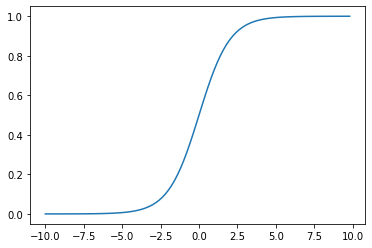

In [ ]:
import math

def safe_sigmoid(x):
    """ The sigmoid is a non-linear activation function that squeezes a value to be in range (0,1). 

    A safe sigmoid that handles pecularities, such as rounding errors, and positive/negative infinity. 

    Args:   
        x (real): The raw input value

    Returns:
        sigmoid: The output is transformed into range (0,1). Returns 0 if Nan. 
    """
    x = 1/(1 + np.exp(-x))
    x = np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
    return x

safe_sigmoid(0)

import matplotlib.pyplot as plt 
x = np.arange(-10., 10., 0.2)
sig = safe_sigmoid(x)
plt.plot(x, sig)
plt.show()

## Operators

In [ ]:
import math
import random
import operator
import csv
import itertools
import multiprocessing

import numpy as np

from deap import algorithms
from deap.algorithms import varAnd
from deap import base
from deap import creator
from deap import tools
from deap import gp


def protectedDiv(left, right):
    """
    Protected division operator that avoids zero division.

    Arg:
        left: The left hand side expression. 
        right: The right hand side expression. 

    Returns: 
        left/right, when right is non-zero value. Otherwise, returns 1. 
    """
    try:
        return left / right
    except ZeroDivisionError:
        return 1


pset = gp.PrimitiveSet("MAIN", n_features)

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

## Fitness Function

In [ ]:
toolbox = base.Toolbox()

minimized = True
if minimized: 
    weight = -1.0 
else: 
    weight = 1.0

mutli_objective = True
if mutli_objective:
    weights = (weight,) * n_classes
else:
    weights = (weight,)

if minimized: 
    creator.create("FitnessMin", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMin)
else:
    creator.create("FitnessMax", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMax)


def compileMultiTree(expr, pset):
    """Compile the expression represented by a list of trees. 

    A variation of the gp.compileADF method, that handles Multi-tree GP. 

    Args: 
        expr: Expression to compile. It can either be a PrimitiveTree,
                 a string of Python code or any object that when
                 converted into string produced a valid Python code
                 expression.
        pset: Primitive Set

    Returns: 
        A set of functions that correspond for each tree in the Multi-tree. 
    """
    funcs = []
    gp_tree = None
    func = None

    for subexpr in expr:
        gp_tree = gp.PrimitiveTree(subexpr)
        func = gp.compile(gp_tree, pset)
        funcs.append(func)
    return funcs

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.expr, n=n_classes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", compileMultiTree)

# p = toolbox.population(n=10)
# first = p[0]
# funcs = toolbox.compile(first, pset)
# f1 = funcs[1]
# f1(*X[0])

In [ ]:
from re import I
from operator import attrgetter
from functools import partial


def xmate(ind1, ind2):
    """ Reproduction operator for multi-tree GP, where trees are represented as a list.

    Crossover happens to each tree, when an individual is selected for crossover. 
    Crossover operations are limited to parents from the same tree.
    

    Args: 
        ind1 (Individual): The first parent. 
        ind2 (Individual): The second parent 

    Returns:
        ind1, ind2 (Individual, Individual): The children from the parents reproduction. 
    """
    n = len(ind1)

    for tree_idx in range(n):
        g1, g2 = gp.PrimitiveTree(ind1[tree_idx]), gp.PrimitiveTree(ind2[tree_idx])
        ind1[tree_idx], ind2[tree_idx] = gp.cxOnePoint(g1, g2)
    return ind1, ind2


def xmut(ind, expr):
    """ Mutation operator for multi-tree GP, where trees are represented as a list. 

    Mutation happens to each tree, when an individual is selected for crossover. 

    Args: 
        ind: The individual, a list of GP trees. 
    """
    n = len(ind)
    
    for tree_idx in range(n):
        g1 = gp.PrimitiveTree(ind[tree_idx])
        indx = gp.mutUniform(g1, expr, pset)
        ind[tree_idx] = indx[0]
    return ind,


def evaluate_classification(individual):
    """ 
    Evalautes the fitness of an individual by its multi-class classification 
    accuracy using a one-vs-all approach. Class labels with onehot encoding, 
    where error is a tuple of length n classes. 

    Args:  
        individual (Individual): A candidate solution to be evaluated. 

    Returns: 
        errors (tuple): Fraction of incorrectly classified instances for each class. 
    """    
    errors = np.zeros(4)
    functions = toolbox.compile(expr=individual, pset=pset)

    def _prediction(x, functions):
        pred = []
        for function in functions:
            prediction = function(*x)
            prediction = safe_sigmoid(prediction)
            pred.append(prediction)
        pred = np.array(pred) 
        return pred 

    def _error(y_true, y_pred):
        error = np.abs(y_true - y_pred)
        return error 
    
    for x,y_true in zip(X,y):
        y_pred = _prediction(x, functions)
        error = _error(y_true, y_pred)
        errors += error
    
    errors /= n_instances 
    errors = tuple(errors)

    return errors


toolbox.register('evaluate', evaluate_classification)

if mutli_objective:
    # Source https://stackoverflow.com/questions/56185786/deap-algorithm-with-several-weights
    toolbox.register("select", tools.selNSGA2)
else:
    toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mate", xmate)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", xmut, expr=toolbox.expr_mut)

import copy
from functools import wraps

def staticLimit(key, max_value):
    """
    A variation of gp.staticLimit that works for Multi-tree representation. 
    This works for our altered xmut and xmate genetic operators for mutli-tree GP. 
    If tree depth limit is exceeded, the genetic operator is reverted. 

    When an invalid (over the limit) child is generated,
    it is simply replaced by one of its parents, randomly selected.
    
    Args:
        key: The function to use in order the get the wanted value. For
             instance, on a GP tree, ``operator.attrgetter('height')`` may
             be used to set a depth limit, and ``len`` to set a size limit.
        max_value: The maximum value allowed for the given measurement. 
             Defaults to 17, the suggested value in (Koza 1992)
    
    Returns: 
        A decorator that can be applied to a GP operator using \
        :func:`~deap.base.Toolbox.decorate`

    References:
        1. Koza, J. R. G. P. (1992). On the programming of computers by means 
            of natural selection. Genetic programming.
    """

    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            # Copy mutli-tree GP. 
            keep_inds = np.array([[copy.deepcopy(tree) for tree in ind] for ind in args])
            # Apply genetic operator, get new individuals. 
            new_inds = list(func(*args, **kwargs))
            
            # Enumerate over the individuals in the genetic operator function. 
            for ind_idx, ind in enumerate(new_inds):
                
                # Enumerate over the multi-tree for the individual. 
                for tree_idx, tree in enumerate(ind):
                    
                    # Check if maximum tree depth exceeded. 
                    if key(tree) > max_value:
                        # When an invalid (over the limit) child is generated,
                        # it is simply replaced by one of its parents, randomly selected.
                        random_parent = random.choice(keep_inds)
                        new_inds[ind_idx][tree_idx] = random_parent[tree_idx]

            return new_inds

        return wrapper

    return decorator

# See https://groups.google.com/g/deap-users/c/pWzR_q7mKJ0
toolbox.decorate("mate", staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate("mutate", staticLimit(key=operator.attrgetter("height"), max_value=8))


def elitism(population):
    """
    Performs simple elitism for Multi-tree GP, ensuring the aggregate tree with
    best fitness for each class, is kept for the next generation. 

    Elitism for Multitree GP ensures monotonous improvement in the classification
    accuracy across the mutliple objective functions for each class. 

    Args: 
        population (list): A list of individuals to perform elitism on. 

    Return:
        population (list): The population with elite appended as first value. 
    """
    fitnesses = toolbox.map(toolbox.evaluate, population)
    best_idxs = []
    best_fitness = []
    
    fitnesses = list(fitnesses)
    if minimized: 
        best_idxs = np.argmin(fitnesses, axis=0)
        best_fitness = np.min(fitnesses, axis=0)
    else: 
        best_idxs = np.argmax(fitnesses, axis=0)
        best_fitness = np.max(fitnesses, axis=0)

    for c_idx, best_idx in enumerate(best_idxs): 
        best_for_class = population[best_idx]
        best_tree = best_for_class[c_idx]
        population[0][c_idx] = best_tree
    population[0].fitness.values = best_fitness 

    return population 


def SimpleGPWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """
    Elitism for Multi-Tree GP for Multi-Class classification. 
    A variation of the eaSimple method from the DEAP library that supports 

    Elitism ensures the best individuals (the elite) from each generation are 
    carried onto the next without alteration. This ensures the quality of the 
    best solution monotonically increases over time. 
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    # [ELITISM] START --------------------------------
    fitnesses = toolbox.map(toolbox.evaluate, population)
    best_idxs = []
    best_fitness = []
    
    fitnesses = list(fitnesses)
    if minimized: 
        best_idxs = np.argmin(fitnesses, axis=0)
        best_fitness = np.min(fitnesses, axis=0)
    else: 
        best_idxs = np.argmax(fitnesses, axis=0)
        best_fitness = np.max(fitnesses, axis=0)

    for c_idx, best_idx in enumerate(best_idxs): 
        best_for_class = population[best_idx]
        best_tree = best_for_class[c_idx]
        population[0][c_idx] = best_tree
    population[0].fitness.values = best_fitness 
    # [ELITISM] END --------------------------------

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    
    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        offspring = toolbox.select(population, len(population) - hof_size)
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        offspring.extend(halloffame.items)
        
        # [ELITISM] START --------------------------------
        fitnesses = toolbox.map(toolbox.evaluate, offspring)
        best_idxs = []
        best_fitness = []
        
        fitnesses = list(fitnesses)
        if minimized: 
            best_idxs = np.argmin(fitnesses, axis=0)
            best_fitness = np.min(fitnesses, axis=0)
        else: 
            best_idxs = np.argmax(fitnesses, axis=0)
            best_fitness = np.max(fitnesses, axis=0)

        for c_idx, best_idx in enumerate(best_idxs): 
            best_for_class = offspring[best_idx]
            best_tree = best_for_class[c_idx]
            offspring[0][c_idx] = best_tree
        offspring[0].fitness.values = best_fitness 
        # [ELITISM] END --------------------------------
        
        halloffame.update(offspring)
        population[:] = offspring
        
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        if verbose:
            print(logbook.stream)

    return population, logbook


def train(generations=100, population=100, elitism=0.1, crossover_rate=0.5, mutation_rate=0.1):
    """
    This is a Multi-tree GP with Elitism for Multi-class classification. 

    Args:
        generations: The number of generations to evolve the populaiton for. 
        elitism: The ratio of elites to be kept between generations. 
        crossover_rate: The probability of a crossover between two individuals. 
        mutation_rate: The probability of a random mutation within an individual.  

    Returns:
        pop: The final population the algorithm has evolved. 
        log: The logbook which can record important statistics. 
        hof: The hall of fame contains the best individual solutions.
    """
    random.seed(420)
    pop = toolbox.population(n=population)
    
    mu = round(elitism * population)
    if elitism > 0:
        # See https://www.programcreek.com/python/example/107757/deap.tools.HallOfFame
        hof = tools.HallOfFame(mu, similar=np.array_equal)
    else:
        hof = None
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    length = lambda a: np.max(list(map(len, a)))
    stats_size = tools.Statistics(length)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)

    mstats.register("avg", partial(np.mean, axis=0))
    mstats.register("std", partial(np.std, axis=0))
    mstats.register("min", partial(np.min, axis=0))
    mstats.register("max", partial(np.max, axis=0))

    pop, log = SimpleGPWithElitism(pop, toolbox, crossover_rate, mutation_rate, 
                                   generations, stats=mstats, halloffame=hof, 
                                   verbose=True)
    # print log
    return pop, log, hof


"""
DeJong (1975), p=50-100, m=0.001, c=0.6 
Grefenstette (1986), p=30, m=0.01, c=0.95
Schaffer et al., (1989), p=20-30, m=0.005-0.01, c=0.75-0.95

References:
    1. Patil, V. P., & Pawar, D. D. (2015). The optimal crossover or mutation 
    rates in genetic algorithm: a review. International Journal of Applied 
    Engineering and Technology, 5(3), 38-41.
"""

generations = 300
population = 100
elitism = 0.1
crossover_rate = 0.95
mutation_rate = 0.1

pop, log, hof = train(generations, population, elitism, crossover_rate, mutation_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

   	      	                                                                                                   fitness                                                                                                   	                      size                     
   	      	-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg                                          	gen	max                                          	min                                          	nevals	std                                          	avg 	gen	max	min	nevals	std    
0  	100   	[0.51208799 0.51638882 0.51863699 0.52532583]	0  	[0.64862575 0.78788253 0.77356739 0.78503975]	[0.40658677 0.35521999 0.19983855 0.31891362]	100   	[0.03846203 0.06274082 0.09142197 0.07302864]	5.13	0  	7  	3  	100   	1.

In [ ]:
file = load('Fish.mat')
X,y = prepare(file)
X,_ = normalize(X,X)
y, _, le = encode_labels(y)

best = hof[0]
funcs = toolbox.compile(best, pset)

acc = 0
for x,y_true in zip(X,y):
    preds = np.array([safe_sigmoid(func(*x)) for func in funcs])
    pred = np.argmax(preds)
    acc += 1 if pred == y_true else 0

acc /= n_instances 
print(f"Best classifiers fitness {labels} : {best.fitness.values}")
print(f"Accuracy: {acc}")

Best classifiers fitness ['BCO' 'GUR' 'SNA' 'TAR'] : (0.14029932160339767, 0.06859711116875643, 0.11688311688311688, 0.12987012987012986)
Accuracy: 0.7012987012987013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


## Visualization

In [ ]:
from deap import base, creator, gp
import pygraphviz as pgv

multi_tree = hof[0]
for t_idx,tree in enumerate(multi_tree): 
    nodes, edges, labels = gp.graph(tree)

    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]

    g.draw(f"tree-{t_idx}.pdf")



## Changelog 

| Date | Title | Description | Update | 
| --- | --- | --- | ---- | 
| 2022-08-21 17:30 | Multi-Objective - Onehot Encoding | Change to multi-objective problem, one-vs-all with a tree classifier for each class.<br> Y labels are encoded in onehot encodings, error is absolute difference between $|\hat{y} - y|$| 
| 2022-08-22 20:44 | Non-linearity |  Introduce $ round . sigmoid $ to evaluate_classification() method.<br>Previously, we push each tree to predict either a 0 or 1 value with the onehot encoding representation.<br>Now, the non-linearity will map any negative value to a negative class 0, and any positive value to positive class 1.|
| 2022-08-22 21:06 | ~~Genetic operators for tree with worst fitness~~ | Only apply the genetic operators, crossover and mutation, to the tree with the worst fitness.<br> This guarantees monotonic improvement for the Multi-tree between generations, the best performing tree remain unaltered.| (Update) This was very slow, and inefficient,<br> basically turned the GP into a single objective,<br>that balances multi-objective fitness functions. | 
| 2022-08-22 21:15 | Halloffame Equality Operator | Numpy equality function (operators.eq) between two arrays returns the equality element wise,<br>which raises an exception in the if similar() check of the hall of fame. <br> Using a different equality function like numpy.array_equal or numpy.allclose solve this issue.| 
| 2022-08-22 23:22 | Elitism as aggregate best tree | Perform elitsim by constructing the best tree, as the tree with best fitness from each clas.<br>The goal is to have monotonous improvement across the multiple objective functions.| 
| 2022-08-22 23:32 | Update fitness for elite | The elitism was not working as intended, as the multi-objectives didn't appear to increase monotnously.<br> This was because the aggregate fitness was not being assigned to the best individual after it was created.<br>Therefore the best invidiual was not passed on to the next generation. | 
| 2022-08-22 02:28 | staticLimit max height | Rewrite the gp.staticLimit decorator function to handle the Multi-tree representation.<br>Note: size and depth are different values!<br>depth is the maximum length of a root-to-leaf traversal,<br>size is the total number of nodes.| 
| 2022-08-24 9:37 | Evaluate Mutli-tree train accuracy | Take the classification accuracy as the argmax for the aggregate multitree.<br> 74% training accuracy, which is not ideal, but this shall improve with time.| 